## Mbovis assemblies from genbank analysis

determines structural differences between all available M.bovis assemblies on genbank

In [243]:
import os, sys, io, random, subprocess
import string
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',600)
import pylab as plt
import seaborn as sns
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})

from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from pybioviz import viewers
from mtbdiff import utils, analysis
import panel as pn
pn.extension()

## run nucdiff

In [ ]:
path = '../bovis_assemblies'
names = analysis.run_genomes(path, outpath='../bovis_results')

## get mtb assemblies info

In [245]:
info = pd.read_csv('../mtbdiff/data/mtb_assemblies.csv')
#print (info.columns)
icols=['Assembly_nover','Strain','BioProject','#Organism/Name','Species']
#info[icols][:20]
#info.to_csv('../mtbdiff/data/mtb_assemblies.csv',index=False)

In [246]:
RD=pd.read_csv(utils.RD_file,comment='#')
RD[:5]

,RD_name,Start,Stop,Size,Rv
0,RD711,1501713,1503655,1943,Rv1333-1336
1,RD702,216795,218516,1722,Rv0186
2,RD12bov,3484700,3487500,2801,Rv3117-3121
3,RD12can,3479400,3491800,12401,Rv3111-3126c
4,RD105,79567,83034,3468,Rv0071-0074


## get nucdiff results

In [256]:
reload(utils)
struct, snp =  utils.get_nucdiff_results('../bovis_results', names)
#get strain
#struct = struct[struct.Name=='deletion']
struct['assembly'] = struct.label.apply(lambda x: x.split('.')[0],1)
struct = struct.merge(info[icols], left_on='assembly',right_on='Assembly_nover',how='left')


In [257]:
struct['RD'] = struct.apply(utils.get_region,1)

In [143]:
#extract bovis names to table
ba = info[info.Assembly_nover.isin(struct.assembly)][icols]
#ba.to_csv('../bovis_assembly_data.csv',index=False)

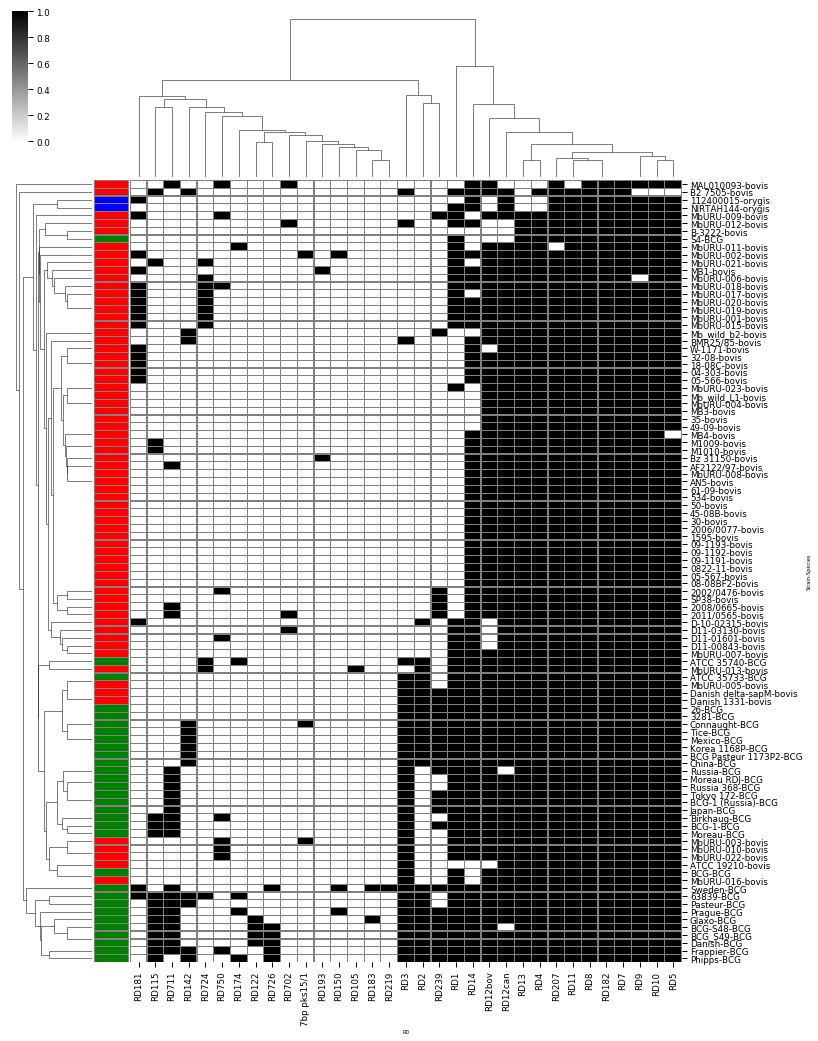

In [284]:
reload(analysis)
reload(utils)

rdmat = utils.RD_matrix(struct, columns=['Strain','Species'])
smat = utils.sites_matrix(struct, columns=['Strain','Species'], freq=10)

species = dm.T.index.get_level_values(1)
lut = dict(zip(species.unique(), "rbg"))
row_colors = species.map(lut)

analysis.plot_RD(rdmat.T,row_colors=row_colors)

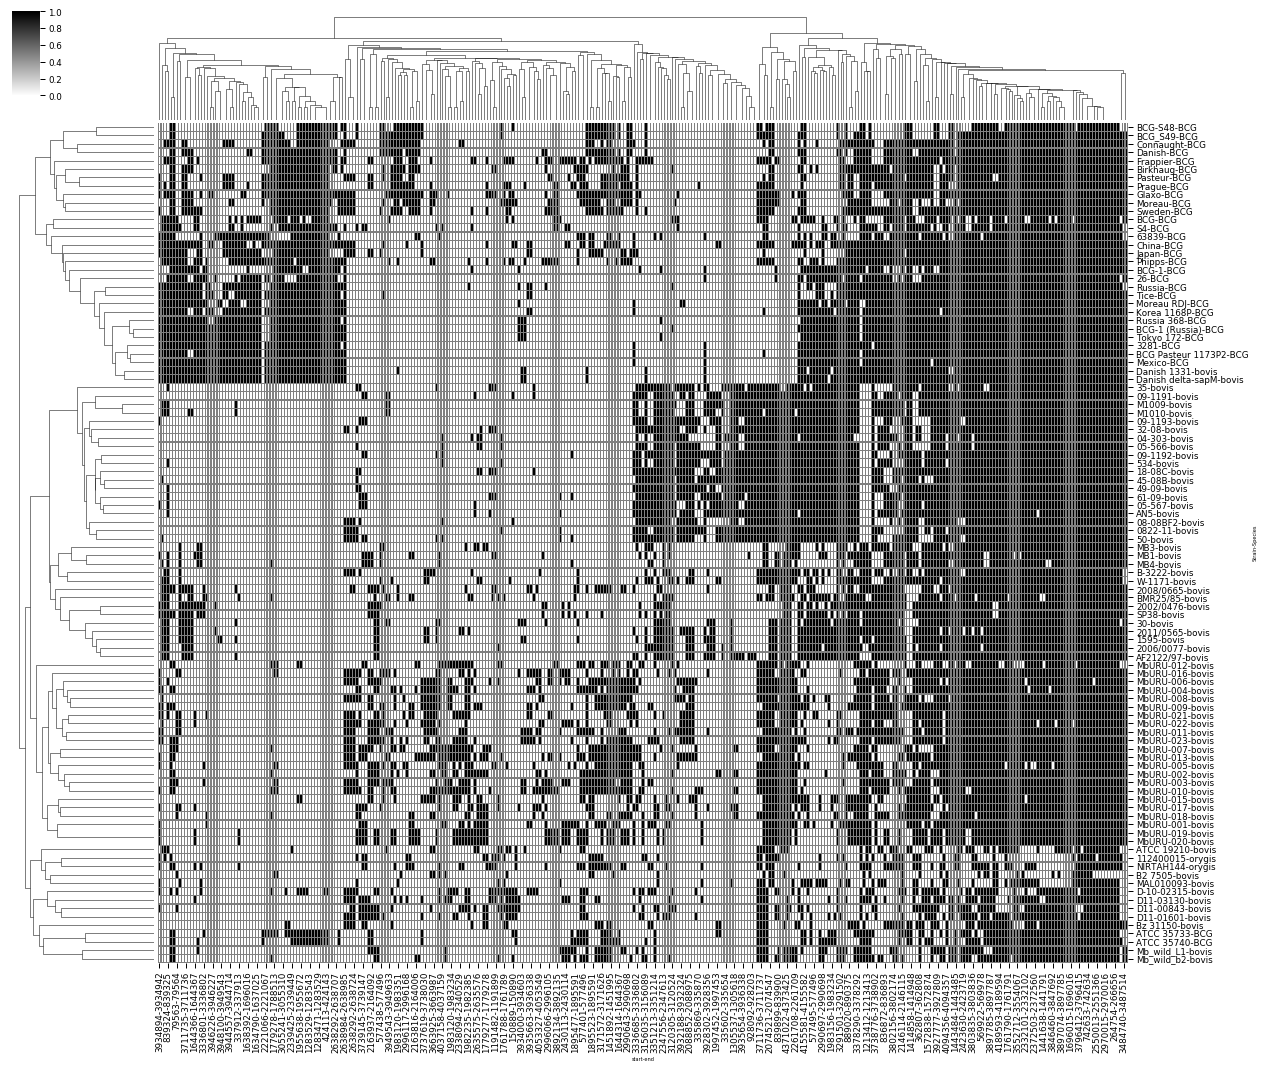

In [286]:
#g=sns.clustermap(smat.T,figsize=(18,19),xticklabels=False,row_colors=row_colors,
#                 yticklabels=True,cmap='gray_r',lw=.5,col_cluster=False)
#g.ax_heatmap.set_title('common indel sites in M.bovis',fontsize=20)
analysis.plot_RD(smat.T, width=20)
#g.savefig('mbovis_indel_sites.png',dpi=150)


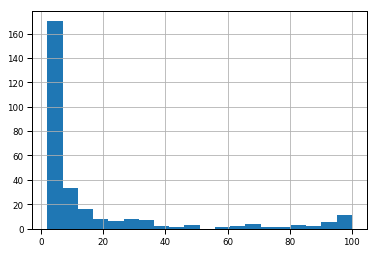

In [242]:
x=dm.sum(1).sort_values(ascending=False)
x.hist(lw=1,bins=20)

## phylogenetic tree

In [ ]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
len(dm.T.values.tolist())
from scipy.spatial import distance_matrix
X=dm.T
dmat = pd.DataFrame(distance_matrix(X.values, X.values), index=X.index, columns=X.index)

matrix = DistanceMatrix(list(dmat.index), np.tril(dmat).tolist())
#constructor = DistanceTreeConstructor()
#tree = constructor.upgma(X)
#print(tree)

## add gene annotation to location info

In [ ]:
def get_annotations(data):
    
    gff_file = analysis.mtb_gff
    mtb_feat = utils.gff_to_dataframe(gff_file)
    mtb_feat = mtb_feat[mtb_feat.gbkey=='Gene']

    #find_regions(comm)
    found = []
    for i,r in data.iterrows():
        #print(r.start,r.end,r.Name)
        df = mtb_feat[((mtb_feat.start<r.start) & (mtb_feat.end>r.end)) |
                       ((mtb_feat.start>r.start) & (mtb_feat.end<r.end))].copy()
        df['change'] = r.Name
        df['query_coord'] = r.query_coord      
        found.append(df)
    found = pd.concat(found)
    found['length'] = found.end-found.start
    print (found)
    
get_annotations(struct)

## bokeh heatmap

In [ ]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, LinearAxis, Grid, Range1d,CustomJS, Slider, HoverTool, NumeralTickFormatter, Arrow, NormalHead
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot, column

def bokeh_heatmap(df):
    source = ColumnDataSource(df) 
     
    tools=[hover,"xpan, xwheel_zoom, save"]
    
    #sequence text view with ability to scroll along x axis
    p = figure(title=None, plot_width=800, plot_height=900, #x_range=x_range,
                y_range=(0,10), tools=tools, min_border=0, toolbar_location='right')
    

In [ ]:
struct[:2]
pd.melt(struct, var_name='var', value_name='del', id_vars=['Strain','start'])#, value_vars=['Name'])

In [ ]:

bokeh_heatmap(delm)